# **Classifying Clothing Images**

In [1]:
# Import the necessary libraries
import numpy as np
import torch
import matplotlib.pyplot as plt

In [5]:
# GPU check
import psutil
import os

torch.cuda.is_available()

True

In [9]:
# Loading the Fashion-MNIST dataset
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

In [10]:
# Examine a sample
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


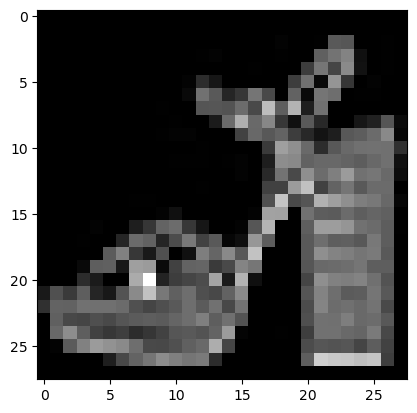

In [11]:
plt.imshow(images[1].numpy().squeeze(), cmap = 'Greys_r')

In [12]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F

model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                     )

# Define the loss
criterion = nn.NLLLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.002)

# Define the epochs
epochs = 15

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1)
    
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30.. Training loss: 0.589.. Test loss: 0.461.. Test Accuracy: 0.836
Epoch: 2/30.. Training loss: 0.433.. Test loss: 0.397.. Test Accuracy: 0.855
Epoch: 3/30.. Training loss: 0.401.. Test loss: 0.385.. Test Accuracy: 0.863
Epoch: 4/30.. Training loss: 0.379.. Test loss: 0.375.. Test Accuracy: 0.864
Epoch: 5/30.. Training loss: 0.361.. Test loss: 0.373.. Test Accuracy: 0.871
Epoch: 6/30.. Training loss: 0.351.. Test loss: 0.359.. Test Accuracy: 0.869
Epoch: 7/30.. Training loss: 0.343.. Test loss: 0.351.. Test Accuracy: 0.876
Epoch: 8/30.. Training loss: 0.336.. Test loss: 0.360.. Test Accuracy: 0.878
Epoch: 9/30.. Training loss: 0.329.. Test loss: 0.353.. Test Accuracy: 0.872
Epoch: 10/30.. Training loss: 0.323.. Test loss: 0.341.. Test Accuracy: 0.879
Epoch: 11/30.. Training loss: 0.314.. Test loss: 0.346.. Test Accuracy: 0.881
Epoch: 12/30.. Training loss: 0.311.. Test loss: 0.337.. Test Accuracy: 0.881
Epoch: 13/30.. Training loss: 0.305.. Test loss: 0.349.. Test Accuracy: 0

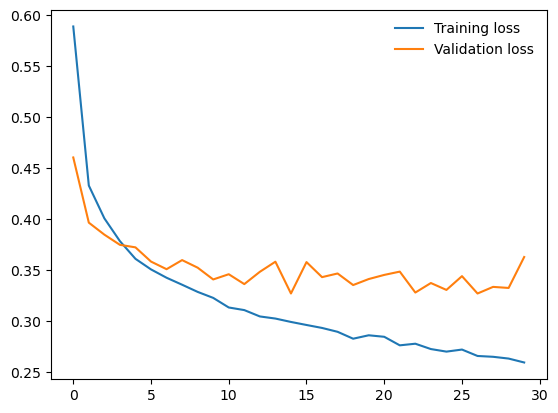

In [13]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)

### Serialize the model

In [20]:
example = torch.rand(64, 1, 784)
print(example.shape)
traced_module = torch.jit.trace(model, example)
traced_module.save("dummy_model.pt")

torch.Size([64, 1, 784])
